#Installation and Imports

In [ ]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import DataParallel
import torch.optim as optim
from sklearn.metrics import classification_report, roc_auc_score, f1_score, recall_score
from sklearn.preprocessing import label_binarize
import time
from torchvision import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import timm
from timm.data import create_transform
#drive.mount('/content/drive')

/home/wnp23/anaconda3/envs/dlProject/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#Data Analysis and Preprocesssing





In [ ]:
#check train directory
import os

for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        num_files = len(os.listdir(class_dir))
        print(f"Class '{class_name}' has {num_files} files")

Class 'Black Hairy' has 309 files
Class 'Termite' has 301 files
Class 'Beet Armyworm' has 199 files
Class 'Jute Semilooper' has 372 files
Class 'Jute Hairy' has 414 files
Class 'Yellow Mite' has 342 files
Class 'Jute Stem Weevil' has 676 files
Class 'Leaf Beetle' has 310 files
Class 'Mealybug' has 466 files
Class 'Scopula Emissaria' has 320 files
Class 'Jute Aphid' has 541 files
Class 'Cutworm' has 399 files
Class 'Field Cricket' has 392 files
Class 'Jute Red Mite' has 457 files
Class 'Pod Borer' has 384 files
Class 'Jute Stem Girdler' has 281 files
Class 'Termite odontotermes (Rambur)' has 301 files


In [ ]:
def count_files_and_classes(directory):
    """Counts the number of files in each class directory."""
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            num_files = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
            class_counts[class_name] = num_files
    return class_counts

def count_instances(directory):
    """Counts the total number of image instances in a directory."""
    total_instances = 0
    for root, dirs, files in os.walk(directory):
        total_instances += len([file for file in files if file.endswith('.jpg') or file.endswith('.png')])
    return total_instances

# Count files and classes in each directory
train_counts = count_files_and_classes(train_dir)
val_counts = count_files_and_classes(val_dir)
test_counts = count_files_and_classes(test_dir)

# Generate and print the class distribution report
total_classes = len(train_counts)
print(f"Total number of classes: {total_classes}\n")
print("Class distribution:\n")
for class_name in train_counts:
    train_count = train_counts.get(class_name, 0)
    val_count = val_counts.get(class_name, 0)
    test_count = test_counts.get(class_name, 0)
    print(f"Class '{class_name}': Train = {train_count}, Val = {val_count}, Test = {test_count}")

# Check if the same classes are present across datasets
same_classes_across_datasets = set(train_counts.keys()) == set(val_counts.keys()) == set(test_counts.keys())
print(f"\nAll datasets have the same classes: {'Yes' if same_classes_across_datasets else 'No'}")

# Count and print the total instances in each dataset
train_instances = count_instances(train_dir)
val_instances = count_instances(val_dir)
test_instances = count_instances(test_dir)
print(f"\nTotal instances - Training dataset: {train_instances}, Validation dataset: {val_instances}, Test dataset: {test_instances}")



Total number of classes: 17

Class distribution:

Class 'Yellow Mite': Train = 342, Val = 30, Test = 24
Class 'Jute Hairy': Train = 414, Val = 8, Test = 20
Class 'Beet Armyworm': Train = 199, Val = 40, Test = 20
Class 'Jute Red Mite': Train = 457, Val = 49, Test = 24
Class 'Jute Stem Girdler': Train = 281, Val = 6, Test = 24
Class 'Pod Borer': Train = 384, Val = 3, Test = 24
Class 'Jute Aphid': Train = 531, Val = 27, Test = 22
Class 'Mealybug': Train = 466, Val = 35, Test = 24
Class 'Cutworm': Train = 399, Val = 18, Test = 20
Class 'Termite': Train = 291, Val = 26, Test = 20
Class 'Black Hairy': Train = 309, Val = 30, Test = 20
Class 'Leaf Beetle': Train = 310, Val = 9, Test = 24
Class 'Jute Stem Weevil': Train = 676, Val = 71, Test = 24
Class 'Jute Semilooper': Train = 372, Val = 5, Test = 21
Class 'Scopula Emissaria': Train = 320, Val = 6, Test = 24
Class 'Field Cricket': Train = 392, Val = 14, Test = 20
Class 'Termite odontotermes (Rambur)': Train = 301, Val = 36, Test = 24

All dat

/tmp/ipykernel_478536/1395915892.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Count', y='Class', hue='Dataset', data=df_melted, ci=None)


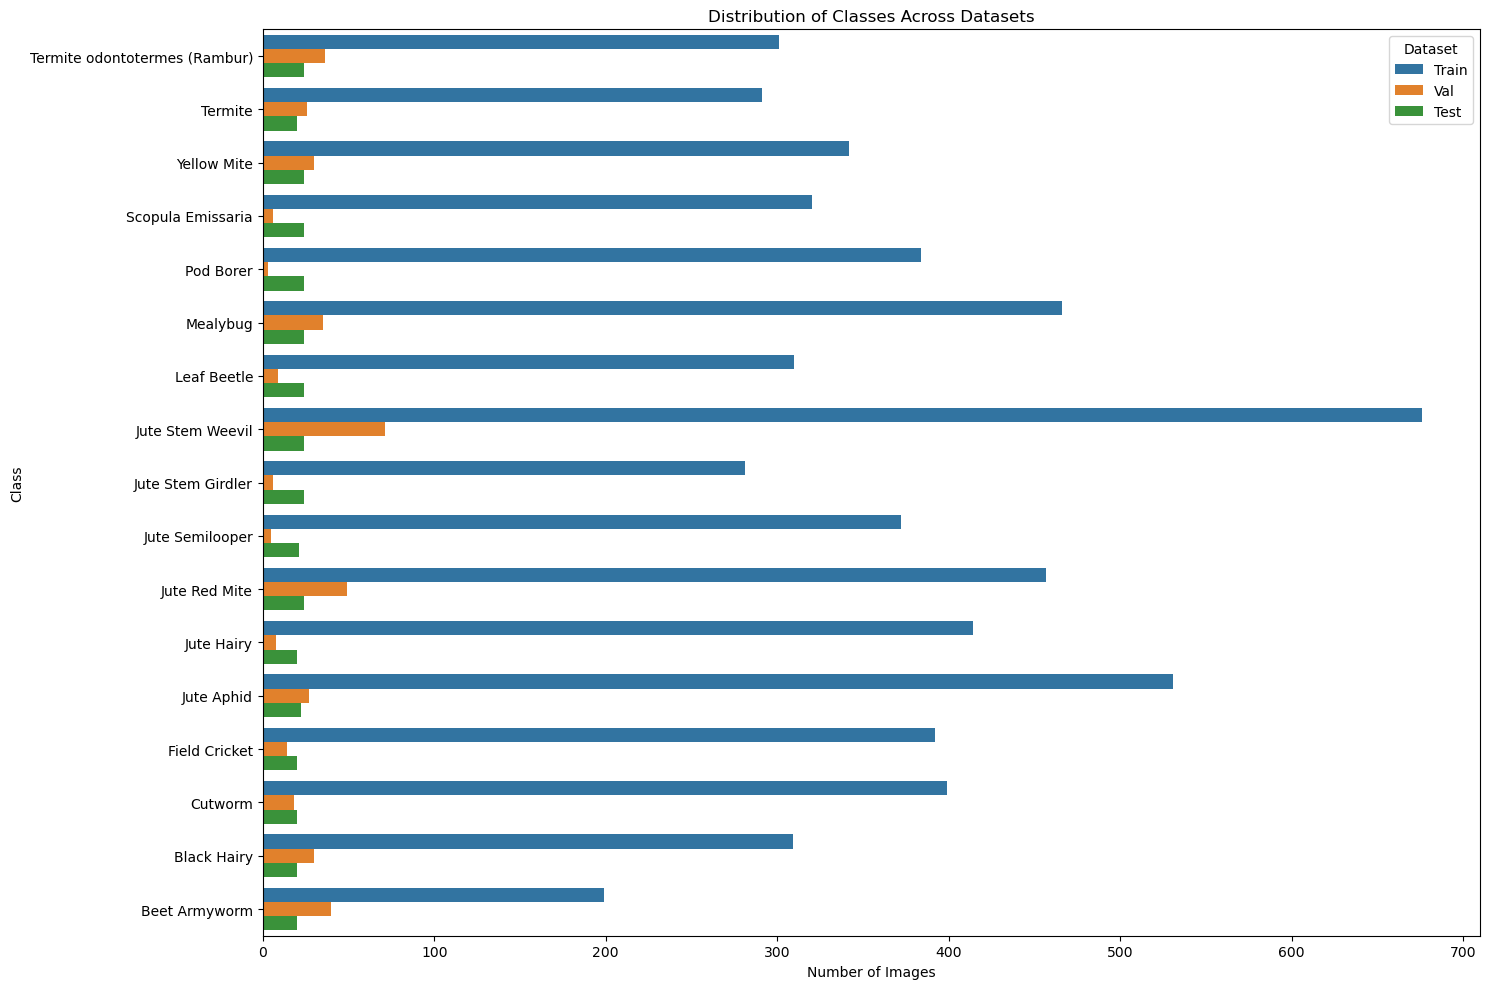

In [ ]:
# class distribution
data = {
    'Class': [
        'Termite odontotermes (Rambur)', 'Termite', 'Yellow Mite', 'Scopula Emissaria',
        'Pod Borer', 'Mealybug', 'Leaf Beetle', 'Jute Stem Weevil',
        'Jute Stem Girdler', 'Jute Semilooper', 'Jute Red Mite', 'Jute Hairy',
        'Jute Aphid', 'Field Cricket', 'Cutworm', 'Black Hairy', 'Beet Armyworm'
    ],
    'Train': [301, 291, 342, 320, 384, 466, 310, 676, 281, 372, 457, 414, 531, 392, 399, 309, 199],
    'Val': [36, 26, 30, 6, 3, 35, 9, 71, 6, 5, 49, 8, 27, 14, 18, 30, 40],
    'Test': [24, 20, 24, 24, 24, 24, 24, 24, 24, 21, 24, 20, 22, 20, 20, 20, 20]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to make it suitable for a seaborn barplot
df_melted = df.melt(id_vars="Class", var_name="Dataset", value_name="Count")

# Create a barplot
plt.figure(figsize=(15, 10))
sns.barplot(x='Count', y='Class', hue='Dataset', data=df_melted, ci=None)

plt.title('Distribution of Classes Across Datasets')
plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.legend(title='Dataset')

plt.tight_layout()
plt.show()


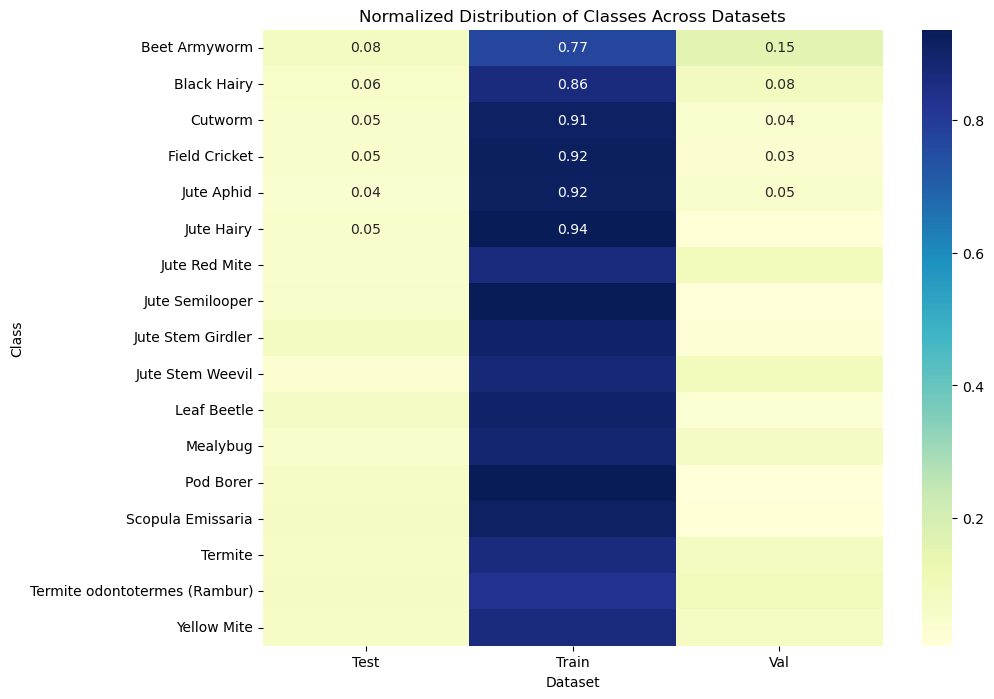

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert data dictionary to DataFrame
df_counts = pd.DataFrame(data)

# Normalize counts for better comparison
df_norm = df_counts.set_index('Class').apply(lambda x: x / x.sum(), axis=1).reset_index()

# Convert to a format suitable for heatmap
df_heatmap = df_norm.melt(id_vars='Class', var_name='Dataset', value_name='Normalized Count')

# Pivot the DataFrame to have classes as rows, datasets as columns
heatmap_data = df_heatmap.pivot(index="Class", columns="Dataset", values="Normalized Count")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Normalized Distribution of Classes Across Datasets')
plt.ylabel('Class')
plt.xlabel('Dataset')
plt.show()


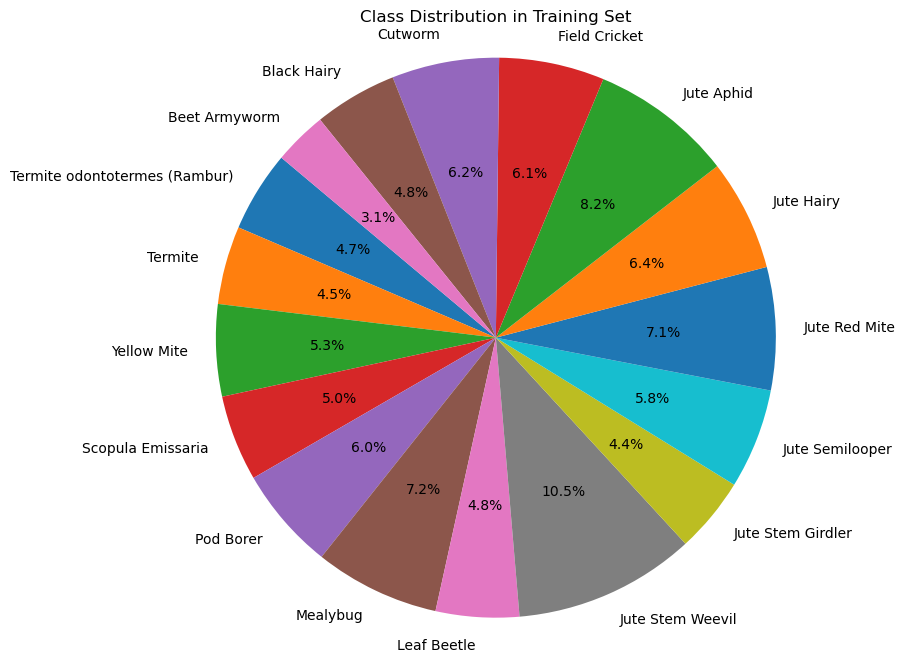

In [ ]:
# Example for the training dataset
plt.figure(figsize=(10, 8))
plt.pie(df_counts['Train'], labels=df_counts['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Training Set')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

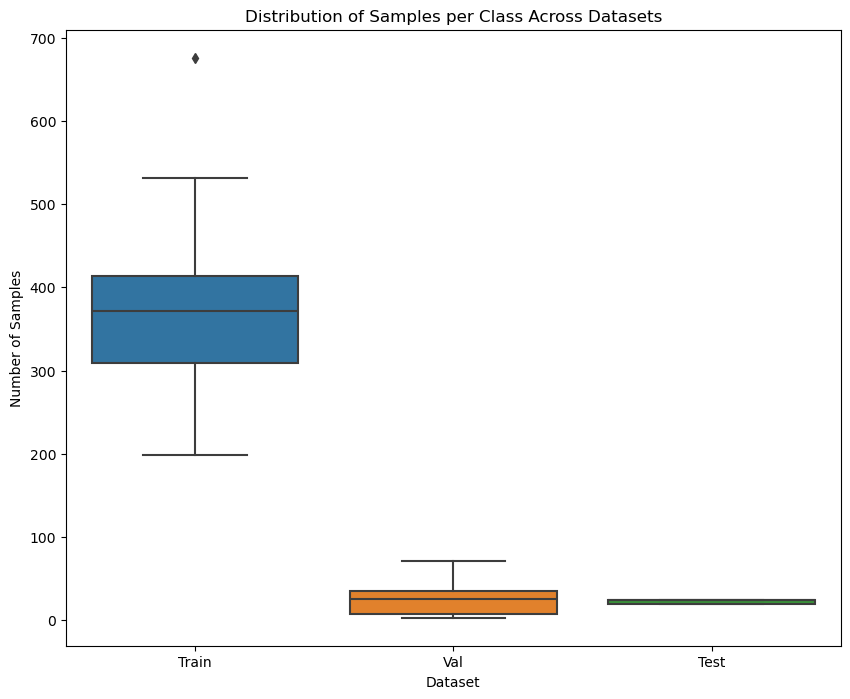

In [ ]:
# Use melted DataFrame for box plot
plt.figure(figsize=(10, 8))
sns.boxplot(x='Dataset', y='Count', data=df_melted)
plt.title('Distribution of Samples per Class Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.show()

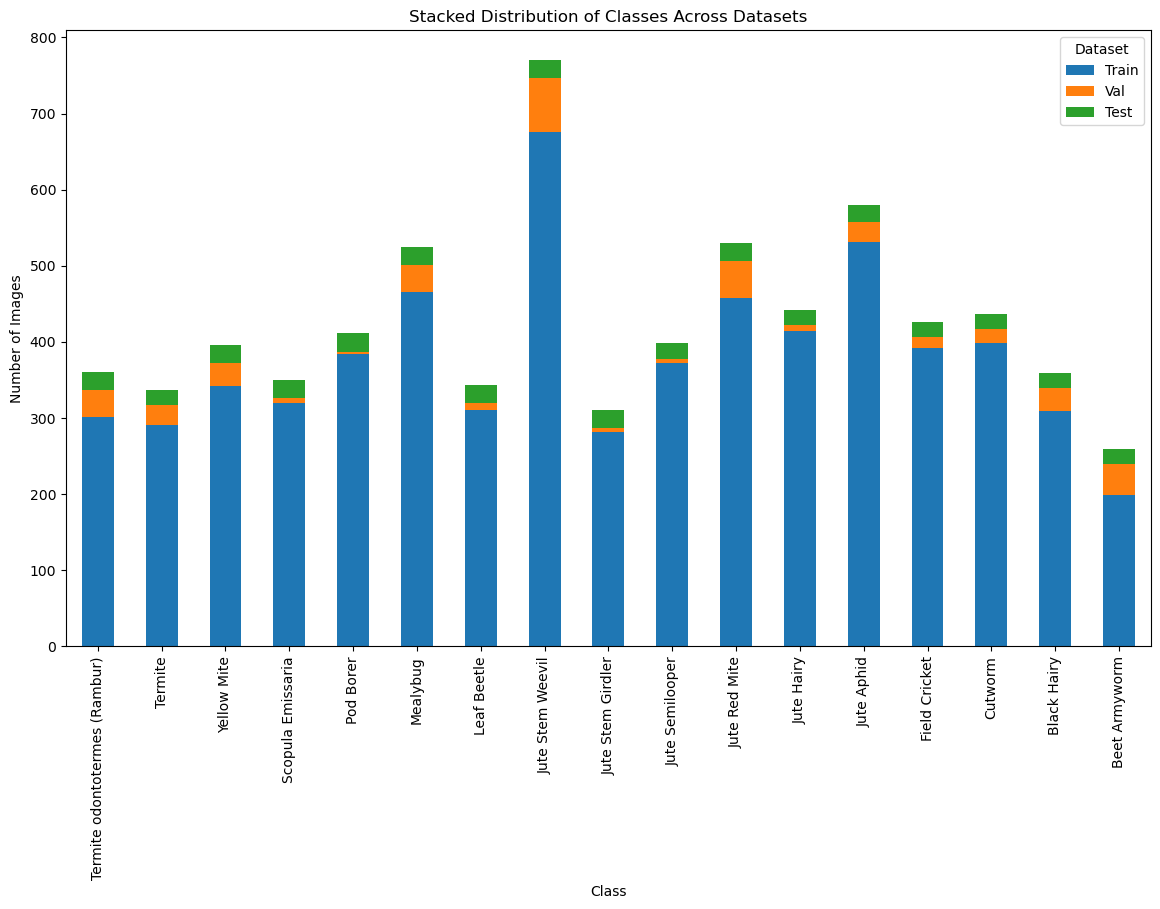

In [ ]:
# Pivot data for stacked bar plot
df_pivot = df_counts.set_index('Class')

# Plot stacked bar plot
df_pivot.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Stacked Distribution of Classes Across Datasets')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.legend(title='Dataset')
plt.show()

In [ ]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
 train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/train', transform=train_transforms)
 val_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/val', transform=test_transforms)
 test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/test', transform=test_transforms)


# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


#CNN

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjusted for the flattening step
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten layer adjustment
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 17

CNN_model = CNNModel(num_classes).to(device)

optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
best_validation_acc = 0.0  # Initialize best validation accuracy
best_model_path = 'best_cnn_model.pth'  # Path to save the best model
total_start_time = time.time()
for epoch in range(100):  # loop over the dataset multiple times
    start_time = time.time()
    CNN_model.train()
    running_loss = 0.0
    train_correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = CNN_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_correct += (outputs.argmax(1) == labels).sum().item()  # Count the number of correct predictions
        total += labels.size(0)
        train_acc = train_correct / total

    # Validation part
    CNN_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        validation_losses = []
        validation_correct = 0
        total_val = 0

        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = CNN_model(inputs)
            loss = criterion(predictions, labels)
            validation_losses.append(loss.item())

            validation_correct += (predictions.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

        validation_loss = np.mean(validation_losses)
        validation_acc = validation_correct / total_val
        end_time = time.time()

        if validation_acc > best_validation_acc:
            best_validation_acc = validation_acc
            torch.save(CNN_model.state_dict(), best_model_path)
            print(f"Saved best model with Val Acc: {validation_acc:.4f}")

    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.4f}, Time: {end_time - start_time} seconds')


Saved best model with Val Acc: 0.2785
Epoch 1, Train Loss: 2.6604, Train Acc: 0.1567, Val Loss: 2.4713, Val Acc: 0.2785, Time: 31.749942779541016 seconds
Saved best model with Val Acc: 0.3559
Epoch 2, Train Loss: 2.3230, Train Acc: 0.2450, Val Loss: 2.2098, Val Acc: 0.3559, Time: 30.99603295326233 seconds
Saved best model with Val Acc: 0.3729
Epoch 3, Train Loss: 2.1003, Train Acc: 0.3144, Val Loss: 2.0863, Val Acc: 0.3729, Time: 31.034099578857422 seconds
Saved best model with Val Acc: 0.3898
Epoch 4, Train Loss: 1.9926, Train Acc: 0.3465, Val Loss: 2.0211, Val Acc: 0.3898, Time: 31.081732511520386 seconds
Saved best model with Val Acc: 0.4649
Epoch 5, Train Loss: 1.8810, Train Acc: 0.3889, Val Loss: 1.9699, Val Acc: 0.4649, Time: 31.10899543762207 seconds
Epoch 6, Train Loss: 1.7775, Train Acc: 0.4190, Val Loss: 1.9246, Val Acc: 0.4286, Time: 31.103437662124634 seconds
Epoch 7, Train Loss: 1.7086, Train Acc: 0.4438, Val Loss: 1.9608, Val Acc: 0.4625, Time: 31.190272569656372 seconds


In [ ]:
# Evaluate
CNN_model.load_state_dict(torch.load(best_model_path))
CNN_model.eval()
true_labels = []
pred_labels = []
total = 0  # Total number of samples
correct = 0  # Correct predictions

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = CNN_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        pred_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # Calculate accuracy
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
true_labels_binarized = label_binarize(true_labels, classes=range(num_classes))
predicted_labels_binarized = label_binarize(pred_labels, classes=range(num_classes))
total_end_time = time.time()
print(f'Test Accuracy: {accuracy:.4f}')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
roc_auc = roc_auc_score(true_labels_binarized, predicted_labels_binarized, average='macro')
print(f'Total Time: {total_end_time - total_start_time} seconds')
print(f'Recall (Macro): {recall:.4f}')
print(f'F1 Score (Macro): {f1:.4f}')
print(f'ROC AUC (Macro): {roc_auc:.4f}')
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

Test Accuracy: 0.8839
Total Time: 3337.635947704315 seconds
Recall (Macro): 0.8798
F1 Score (Macro): 0.8753
ROC AUC (Macro): 0.9363
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.40      0.48        20
           1       0.80      1.00      0.89        20
           2       0.81      0.65      0.72        20
           3       0.87      1.00      0.93        20
           4       0.85      1.00      0.92        22
           5       0.74      1.00      0.85        20
           6       0.92      0.92      0.92        24
           7       0.94      0.71      0.81        21
           8       1.00      1.00      1.00        24
           9       0.62      0.75      0.68        24
          10       1.00      1.00      1.00        24
          11       1.00      0.75      0.86        24
          12       0.96      1.00      0.98        24
          13       1.00      0.92      0.96        24
          14       1.00      0.90 

# Densenet

In [ ]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize(299),
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/val', transform=test_transforms)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/test', transform=test_transforms)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize DenseNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 17)
model = model.to(device)
model = DataParallel(model)
# Optimizer and Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

best_validation_acc = 0.0  # Initialize best validation accuracy
best_model_path = 'best_densenet_model.pth'  # Path to save the best model
total_start_time = time.time()
# Training loop
for epoch in range(100):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    train_correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
        train_acc = train_correct / total

    # Validation phase
    model.eval()
    validation_losses = []
    validation_correct = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            validation_losses.append(loss.item())

            validation_correct += (predictions.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

        validation_loss = sum(validation_losses) / len(validation_losses)
        validation_acc = validation_correct / total_val

    end_time = time.time()
    if validation_acc > best_validation_acc:
            best_validation_acc = validation_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with Val Acc: {validation_acc:.4f}")

    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.4f}, Time: {end_time - start_time} seconds')

# Evaluate
model.load_state_dict(torch.load(best_model_path))
model.eval()
true_labels = []
pred_labels = []
total = 0
correct = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu()
        pred_labels.extend(predicted.numpy())
        true_labels.extend(labels.cpu().numpy())

        correct += (predicted == labels.cpu()).sum().item()
        total += labels.size(0)
total_end_time = time.time()
accuracy = correct / total
print(f'Total Time: {total_end_time - total_start_time} seconds')
print(f'Test Accuracy: {accuracy:.4f}')
print("Classification Report:")
print(classification_report(true_labels, pred_labels))


/home/wnp23/anaconda3/envs/dlProject/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wnp23/anaconda3/envs/dlProject/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saved best model with Val Acc: 0.6683
Epoch 1, Train Loss: 1.0221, Train Acc: 0.6929, Val Loss: 1.1527, Val Acc: 0.6683, Time: 63.102272510528564 seconds
Saved best model with Val Acc: 0.7918
Epoch 2, Train Loss: 0.5650, Train Acc: 0.8229, Val Loss: 0.6975, Val Acc: 0.7918, Time: 63.41201567649841 seconds
Epoch 3, Train Loss: 0.4664, Train Acc: 0.8489, Val Loss: 0.8929, Val Acc: 0.7603, Time: 63.58533310890198 seconds
Saved best model with Val Acc: 0.8232
Epoch 4, Train Loss: 0.3673, Train Acc: 0.8872, Val Loss: 0.6411, Val Acc: 0.8232, Time: 63.48188638687134 seconds
Saved best model with Val Acc: 0.8523
Epoch 5, Train Loss: 0.3373, Train Acc: 0.8988, Val Loss: 0.5811, Val Acc: 0.8523, Time: 63.49171233177185 seconds
Epoch 6, Train Loss: 0.3085, Train Acc: 0.9043, Val Loss: 0.8568, Val Acc: 0.7990, Time: 63.582523822784424 seconds
Epoch 7, Train Loss: 0.2885, Train Acc: 0.9125, Val Loss: 0.5512, Val Acc: 0.8523, Time: 63.53884434700012 seconds
Epoch 8, Train Loss: 0.2662, Train Acc: 0

# VGG16

In [ ]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/val', transform=test_transforms)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/test', transform=test_transforms)

# Data loaders
batch_size = 32  # VGG is more memory intensive, might need to reduce batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize VGG model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)
for param in model.features.parameters():  # Freeze all feature layers
    param.requires_grad = False

# Replace the classifier to fit our dataset
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 17)
model = model.to(device)
# Optimizer and Loss function
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # Only optimize classifier parameters
criterion = nn.CrossEntropyLoss()
model = DataParallel(model)

best_validation_acc = 0.0  # Initialize best validation accuracy
best_model_path = 'best_vgg_model.pth'  # Path to save the best model
total_start_time = time.time()
# Training loop
for epoch in range(100):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    train_correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
        train_acc = train_correct / total

    # Validation phase
    model.eval()
    validation_losses = []
    validation_correct = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            validation_losses.append(loss.item())

            validation_correct += (predictions.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

        validation_loss = sum(validation_losses) / len(validation_losses)
        validation_acc = validation_correct / total_val

    end_time = time.time()
    if validation_acc > best_validation_acc:
            best_validation_acc = validation_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with Val Acc: {validation_acc:.4f}")

    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.4f}, Time: {end_time - start_time} seconds')

# Evaluate
model.load_state_dict(torch.load(best_model_path))
model.eval()
true_labels = []
pred_labels = []
total = 0
correct = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu()
        pred_labels.extend(predicted.numpy())
        true_labels.extend(labels.cpu().numpy())

        correct += (predicted == labels.cpu()).sum().item()
        total += labels.size(0)

total_end_time = time.time()
accuracy = correct / total
print(f'Total Time: {total_end_time - total_start_time} seconds')
print(f'Test Accuracy: {accuracy:.4f}')
print("Classification Report:")
print(classification_report(true_labels, pred_labels))


/home/wnp23/anaconda3/envs/dlProject/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wnp23/anaconda3/envs/dlProject/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saved best model with Val Acc: 0.7627
Epoch 1, Train Loss: 1.4552, Train Acc: 0.5847, Val Loss: 1.0880, Val Acc: 0.7627, Time: 109.53411412239075 seconds
Saved best model with Val Acc: 0.8087
Epoch 2, Train Loss: 1.1599, Train Acc: 0.7142, Val Loss: 1.1824, Val Acc: 0.8087, Time: 109.64964962005615 seconds
Saved best model with Val Acc: 0.8305
Epoch 3, Train Loss: 1.1601, Train Acc: 0.7564, Val Loss: 1.1930, Val Acc: 0.8305, Time: 109.69650959968567 seconds
Epoch 4, Train Loss: 1.0934, Train Acc: 0.7720, Val Loss: 1.6816, Val Acc: 0.7966, Time: 109.61963534355164 seconds
Saved best model with Val Acc: 0.8378
Epoch 5, Train Loss: 1.2440, Train Acc: 0.7632, Val Loss: 0.9534, Val Acc: 0.8378, Time: 109.58545398712158 seconds
Saved best model with Val Acc: 0.8499
Epoch 6, Train Loss: 1.1141, Train Acc: 0.7762, Val Loss: 1.1676, Val Acc: 0.8499, Time: 109.56131315231323 seconds
Saved best model with Val Acc: 0.8547
Epoch 7, Train Loss: 0.9586, Train Acc: 0.8040, Val Loss: 1.6515, Val Acc: 0

# Resnet50+Random forest

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/val', transform=val_transforms)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/test', transform=test_transforms)


# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load a pre-trained ResNet50 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)
resnet50.eval()  # Set the model to evaluation mode

# Function to extract features
def extract_features(loader):
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = resnet50(inputs)
            outputs = torch.flatten(outputs, 1)  # Flatten the outputs
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extract features
train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)
test_features, test_labels = extract_features(test_loader)

# Hyperparameters grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

start_time = time.time()
# Grid search for hyperparameter tuning
rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(train_features, train_labels)

# Best model
best_rf = grid_search.best_estimator_

# Evaluate the best model on validation and test sets
val_predictions = best_rf.predict(val_features)
test_predictions = best_rf.predict(test_features)

end_time = time.time()

print(f'Total time: {end_time-start_time}')
print("Validation Set Classification Report:")
print(classification_report(val_labels, val_predictions))

print("Test Set Classification Report:")
print(classification_report(test_labels, test_predictions))


/home/wnp23/anaconda3/envs/dlProject/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wnp23/anaconda3/envs/dlProject/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  15.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  13.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  13.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  13.7s
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=  15.5s
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=  15.7s
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=  15.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  15.9s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  16.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  16.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  16.2s
[CV] END max_depth=None, min

# Resnet + Vit Hybrid

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, roc_auc_score, f1_score, recall_score
from sklearn.preprocessing import label_binarize
from torch.nn import DataParallel
import math
import numpy as np
import seaborn as sns
from torchvision.models import resnet50, ResNet50_Weights
import timm

#https://drive.google.com/drive/folders/1i4DBvoQkzniIVB0B_jGbxf_t_8NQ5svY?usp=drive_link
train_dir = '/content/drive/MyDrive/Jute_Pest_Dataset/train'
#https://drive.google.com/drive/folders/1VoiMki5ZPtNkxiR3QluJP6fW5G6fOIh2?usp=drive_link
val_dir = '/content/drive/MyDrive/Jute_Pest_Dataset/val'
#https://drive.google.com/drive/folders/1YM_ouO28aSP72-qU0USGAvfvzV3MYx3S?usp=drive_link
test_dir = '/content/drive/MyDrive/Jute_Pest_Dataset/test'

# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/val', transform=test_transforms)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Jute_Pest_Dataset/test', transform=test_transforms)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

class ResNet50_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Initialize ResNet50 with pre-trained weights
        self.resnet = resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final classification layer

        # Initialize ViT from timm
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
        self.vit.head = nn.Identity()  # Remove the classification head as we will use a custom one later

        # Adjust the classifier to the combined features of ResNet and ViT
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2816, 500),  # Adjust the input features to the sum of both feature sizes
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(500, num_classes)
        )

    def forward(self, x):
        # Extract features from ResNet50
        resnet_features = self.resnet(x)
        # Extract features from ViT
        # We need to resize images to 224x224 if not already since ViT model from timm expects this input size
        if x.shape[-2:] != (224, 224):
            x_resized = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        else:
            x_resized = x
        vit_features = self.vit(x_resized)
        # Combine features
        combined_features = torch.cat((resnet_features, vit_features), dim=1)
        # Classifier for final predictions
        logits = self.classifier(combined_features)

        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50_ViT_Hybrid(num_classes=17).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_classes=17

best_validation_acc = 0.0  # Initialize best validation accuracy
best_model_path = 'best_resnetvit_model.pth'  # Path to save the best model
total_start_time = time.time()

for epoch in range(200):  # loop over the dataset multiple times
    start_time = time.time()
    train_correct = 0
    total = 0
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Convert probabilities to binary predictions
        train_correct += (outputs.argmax(1) == labels).sum().item()  # Count the number of correct predictions
        total += labels.size(0)
        train_acc = train_correct / total

    # Validation part
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        validation_losses = []
        validation_correct = 0
        total_val = 0

        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            validation_losses.append(loss.item())

            validation_correct += (predictions.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

        validation_loss = np.mean(validation_losses)
        validation_acc = validation_correct / total_val
        end_time = time.time()

        if validation_acc > best_validation_acc:
            best_validation_acc = validation_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with Val Acc: {validation_acc:.4f}")

    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.4f}, Time: {end_time - start_time} seconds')


# Evaluate
model.load_state_dict(torch.load(best_model_path))
model.eval()
true_labels = []
pred_labels = []
total = 0  # Total number of samples
correct = 0  # Correct predictions

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        pred_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # Calculate accuracy
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
true_labels_binarized = label_binarize(true_labels, classes=range(num_classes))
predicted_labels_binarized = label_binarize(pred_labels, classes=range(num_classes))
total_end_time = time.time()

print(f'Accuracy: {accuracy:.4f}')
print(f'Total Time: {total_end_time - total_start_time} seconds')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
roc_auc = roc_auc_score(true_labels_binarized, predicted_labels_binarized, average='macro')

print(f'Recall (Macro): {recall:.4f}')
print(f'F1 Score (Macro): {f1:.4f}')
print(f'ROC AUC (Macro): {roc_auc:.4f}')
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

Saved best model with Val Acc: 0.4504
Epoch 1, Train Loss: 2.0734, Train Acc: 0.3612, Val Loss: 2.9080, Val Acc: 0.4504, Time: 109.47963166236877 seconds
Saved best model with Val Acc: 0.5569
Epoch 2, Train Loss: 1.5345, Train Acc: 0.5391, Val Loss: 1.5680, Val Acc: 0.5569, Time: 110.15913510322571 seconds
Saved best model with Val Acc: 0.5884
Epoch 3, Train Loss: 1.2606, Train Acc: 0.6106, Val Loss: 1.5466, Val Acc: 0.5884, Time: 110.32448887825012 seconds
Saved best model with Val Acc: 0.6150
Epoch 4, Train Loss: 1.0606, Train Acc: 0.6773, Val Loss: 1.4328, Val Acc: 0.6150, Time: 110.22160816192627 seconds
Epoch 5, Train Loss: 0.9638, Train Acc: 0.7164, Val Loss: 1.6364, Val Acc: 0.5763, Time: 110.21110081672668 seconds
Saved best model with Val Acc: 0.6562
Epoch 6, Train Loss: 0.8823, Train Acc: 0.7382, Val Loss: 1.3532, Val Acc: 0.6562, Time: 110.27262735366821 seconds
Epoch 7, Train Loss: 0.8304, Train Acc: 0.7517, Val Loss: 1.7051, Val Acc: 0.6077, Time: 110.22935962677002 second